In [43]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter
import src.kgbench as kg
import fire, sys
import math

from kgbench import load, tic, toc, d


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors


# #
#from torch_geometric.utils import to_networkx
# import networkx as nx

from src.rgcn_explainer_utils import *
from IPython.core.interactiveshell import InteractiveShell
from rgcn import RGCN

import stat
import numpy as np
from scipy.stats import chi2_contingency

In [44]:
import os

# Get the current directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Check if the current directory is already the parent directory
if current_dir != '/Users/macoftraopia/Documents/GitHub/RGCN-Explainer':
    # Set the parent directory as the current directory
    os.chdir(parent_dir)
!pwd

/Users/macoftraopia/Documents/GitHub/RGCN-Explainer


In [67]:
from src.rgcn_explainer_utils import *
name = 'aifb'
if name in ['aifb', 'mutag', 'bgs', 'am', 'mdgenre', 'amplus', 'dmg777k']:
    data = kg.load(name, torch=True, final=False)
if 'IMDb' in name:    
    data = torch.load(f'data/IMDB/finals/{name}.pt')
if 'dbo' in name:
    data = torch.load(f'data/DBO/finals/{name}.pt')
get_relations(data)
relations = [data.i2rel[i][0] for i in range(len(data.i2rel))]
data.triples = torch.Tensor(data.triples).to(int)
data.withheld = torch.Tensor(data.withheld).to(int)
data.training = torch.Tensor(data.training).to(int)
print('rel:', data.num_relations, 'ent:', data.num_entities, 'triples:', data.triples.shape)
print('training', data.training.shape, 'withheld', data.withheld.shape)

loaded data aifb (0.2588s).
rel: 45 ent: 8285 triples: torch.Size([29043, 3])
training torch.Size([103, 2]) withheld torch.Size([35, 2])


RELATION DISTRIBUTION

In [68]:
def bar_plot_relations(full_graph_relations, explanation_subgraph_relations,label_class=None, ax = None):
    
    # Convert dictionaries to pandas DataFrame
    full_graph_df = pd.DataFrame(list(full_graph_relations.items()), columns=['Relation Name', 'Count'])
    explanation_df = pd.DataFrame(list(explanation_subgraph_relations.items()), columns=['Relation Name', 'Count'])

    # Merge the DataFrames and calculate the total counts
    merged_df = pd.merge(full_graph_df, explanation_df, on='Relation Name', how='outer', suffixes=('_full', '_explanation'))
    merged_df = merged_df.fillna(0)
    total_full_graph = merged_df['Count_full'].sum()
    total_explanation = merged_df['Count_explanation'].sum()

    # Calculate the percentages for each relation in both full graph and explanation subgraph
    merged_df['Percentage_full'] = merged_df['Count_full'] / total_full_graph * 100
    merged_df['Percentage_explanation'] = merged_df['Count_explanation'] / total_explanation * 100

    # Sort the DataFrame by the counts in descending order
    sorted_df = merged_df.sort_values(by='Count_full', ascending=False)

    # Create the bar plot (histograms with adjacent bars)
    bar_width = 0.4
    bar_positions_full_graph = np.arange(len(sorted_df))
    bar_positions_explanation = bar_positions_full_graph + bar_width

    plt.figure(figsize=(12, 6))

    # Plot the full graph data in blue color
    plt.bar(bar_positions_full_graph, sorted_df['Percentage_full'], width=bar_width, alpha=0.7, color='blue', edgecolor='black', label='Full Graph')

    # Plot the explanation subgraph data in green color
    plt.bar(bar_positions_explanation, sorted_df['Percentage_explanation'], width=bar_width, alpha=0.7, color='green', edgecolor='black', label='Explanation Subgraph')

    # Set the x-axis ticks and labels
    plt.xticks(bar_positions_full_graph + bar_width / 2, sorted_df['Relation Name'], rotation=45)

    plt.xlabel('Relation Name')
    plt.ylabel('Relative Frequency (%)')
    plt.title(f'Distribution of Relations per class {label_class}')
    plt.legend(loc='upper right')
    #plt.show()
    return plt.gca()


def keep_columns_with_non_zero_values(df):
    ''' Keep only columns with non-zero values'''

    df = df.fillna(0)
    # Get the column names with non-zero values
    non_zero_columns = df.columns[df.astype(bool).any(axis=0)]

    # Create a new DataFrame with only the columns containing non-zero values
    modified_df = df[non_zero_columns]

    return modified_df


def stat_test(full, explain):
    common_relations = set(full.keys()).intersection(explain.keys())

    # Extract the counts for common relations
    full_graph_counts = np.array([full[relation] for relation in common_relations])
    explanation_counts = np.array([explain[relation] for relation in common_relations])

    # Perform chi-squared test
    observed = np.array([full_graph_counts, explanation_counts])
    chi2, p, _, _ = chi2_contingency(observed)

    print("Chi-Squared Statistic:", chi2)
    print("P-value:", p)

def modified_counter(path,relations):
    df = pd.read_csv(path, index_col = 'label')[relations]
    df = keep_columns_with_non_zero_values(df)
    mean_df = df.groupby('label').mean()
    return mean_df   
exp = 'init_normal_lr_0.5_size_0.0005_ent_1_type_1_wd_0.9_MFR_1'

In [157]:
#exp = 'init_normal_lr_0.5_size_0.005_ent_1_type_1_wd_0.9_MFR_1_killMFR_False'
exp = 'init_normal_hops_2_lr_0.5_adaptive_False_size_0.005_sizestd_adaptive_ent_1_type_1_killtype_True_break_no'
path = f'chk/{name}_chk/bro/exp/{exp}/Relation_Importance/'
full = modified_counter(path+'/Relations_Important_full_neighborhood.csv',relations)
explain = modified_counter(path+'/Relations_Important_sample_threshold.csv',relations)



In [158]:
df1 = pd.read_csv(path + '/Relations_Important_full_neighborhood.csv')
df2 = pd.read_csv(path + '/Relations_Important_sample_threshold.csv')
df1 = df1.set_index('label')
df2 = df2.set_index('label')
df1 = keep_columns_with_non_zero_values(df1)
df2 = keep_columns_with_non_zero_values(df2)
common_relations = set(full.keys()).intersection(explain.keys())
df1 = df1[common_relations]
df2 = df2[common_relations]
# df1 =df1 / df1.sum(axis=0)
# df2 =df2 / df2.sum(axis=0)


import pandas as pd
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

# Assuming you have two dataframes 'df1' and 'df2'

# List to store results of the t-test for each feature
t_test_results = []

# Loop through each column (feature)
for col in df1.columns:
    # Perform a two-sample t-test between df1[col] and df2[col]
    t_statistic, p_value = ttest_ind(df1[col], df2[col], equal_var=False)
    #t_statistic, p_value = mannwhitneyu(df1[col], df2[col])
    
    
    
    # Store the t-test results in a dictionary
    result = {'Feature': col, 'T-Statistic': t_statistic, 'P-Value': p_value}
    t_test_results.append(result)

# Create a DataFrame from the t-test results
t_test_results_df = pd.DataFrame(t_test_results)
print(t_test_results_df)

# Filter for statistically significant results (you can set a significance level, e.g., 0.05)
# significance_level = 0.05
# statistically_significant = t_test_results_df[t_test_results_df['P-Value'] < significance_level]

# print(statistically_significant)


          Feature  T-Statistic   P-Value
0        homepage     1.046718  0.317005
1            name     5.380276  0.000036
2    isWorkedOnBy     3.276552  0.007133
3     publication     2.437662  0.032894
4          member     3.285522  0.006437
5             fax     2.227075  0.038285
6           phone     1.326285  0.203797
7           photo     3.540464  0.002376
8          author     2.338374  0.039189
9  worksAtProject     2.376336  0.035903


/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_66468/3746610601.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df1 = df1[common_relations]
/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_66468/3746610601.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df2 = df2[common_relations]


In [146]:
from scipy.stats import wilcoxon

wilcoxon_results = []

# Loop through each column (feature)
for col in df1.columns:
    # Perform the Wilcoxon signed-rank test between df1[col] and df2[col]
    statistic, p_value = wilcoxon(df1[col], df2[col])
    
    # Store the test results in a dictionary
    result = {'Feature': col, 'Wilcoxon Statistic': statistic, 'P-Value': p_value}
    wilcoxon_results.append(result)

# Create a DataFrame from the Wilcoxon signed-rank test results
wilcoxon_results_df = pd.DataFrame(wilcoxon_results)

# Filter for statistically significant results (you can set a significance level, e.g., 0.05)
significance_level = 0.05
statistically_significant = wilcoxon_results_df[wilcoxon_results_df['P-Value'] < significance_level]

print(statistically_significant)

          Feature  Wilcoxon Statistic   P-Value
0        homepage                 0.0  0.033895
1            name                 0.0  0.003892
2    isWorkedOnBy                 0.0  0.005062
3     publication                 0.0  0.005062
4          member                 0.0  0.005034
5             fax                 0.0  0.000488
6           phone                 0.0  0.004892
7           photo                 0.0  0.008151
8          author                 0.0  0.005062
9  worksAtProject                 0.0  0.011616


/usr/local/Caskroom/miniconda/base/envs/RGCNExplainer/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/Caskroom/miniconda/base/envs/RGCNExplainer/lib/python3.9/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [137]:
df1

,homepage,name,isWorkedOnBy,publication,member,fax,phone,photo,author,worksAtProject
0,0.000000,0.153846,0.040761,0.019400,0.000000,0.018824,0.012876,0.090909,0.019469,0.000000
1,0.857143,0.076923,0.000000,0.007055,0.000000,0.152941,0.300429,0.000000,0.007080,0.000000
2,0.035714,0.076923,0.141304,0.100529,0.100746,0.001176,0.004292,0.090909,0.097345,0.024390
3,0.035714,0.076923,0.016304,0.021164,0.082090,0.152941,0.004292,0.090909,0.021239,0.073171
4,0.035714,0.076923,0.127717,0.077601,0.029851,0.152941,0.004292,0.090909,0.077876,0.065041
5,0.000000,0.076923,0.059783,0.033510,0.059701,0.004706,0.008584,0.090909,0.033628,0.024390
6,0.035714,0.076923,0.225543,0.393298,0.100746,0.022353,0.021459,0.090909,0.394690,0.170732
7,0.000000,0.076923,0.176630,0.164021,0.250000,0.020000,0.021459,0.090909,0.164602,0.333333
8,0.000000,0.076923,0.160326,0.146384,0.175373,0.015294,0.008584,0.090909,0.146903,0.170732
9,0.000000,0.076923,0.016304,0.037037,0.089552,0.152941,0.300429,0.090909,0.037168,0.089431


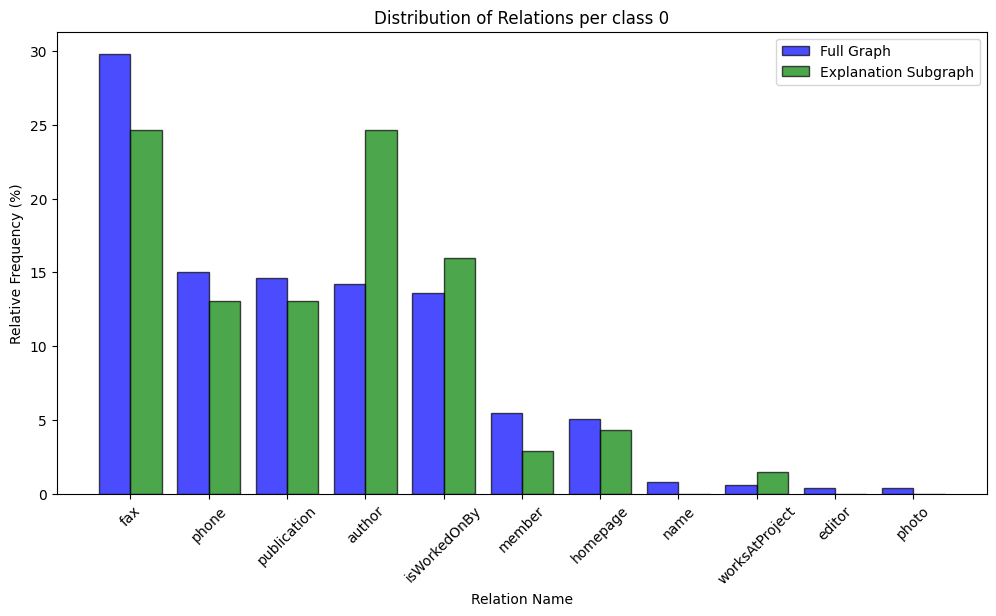

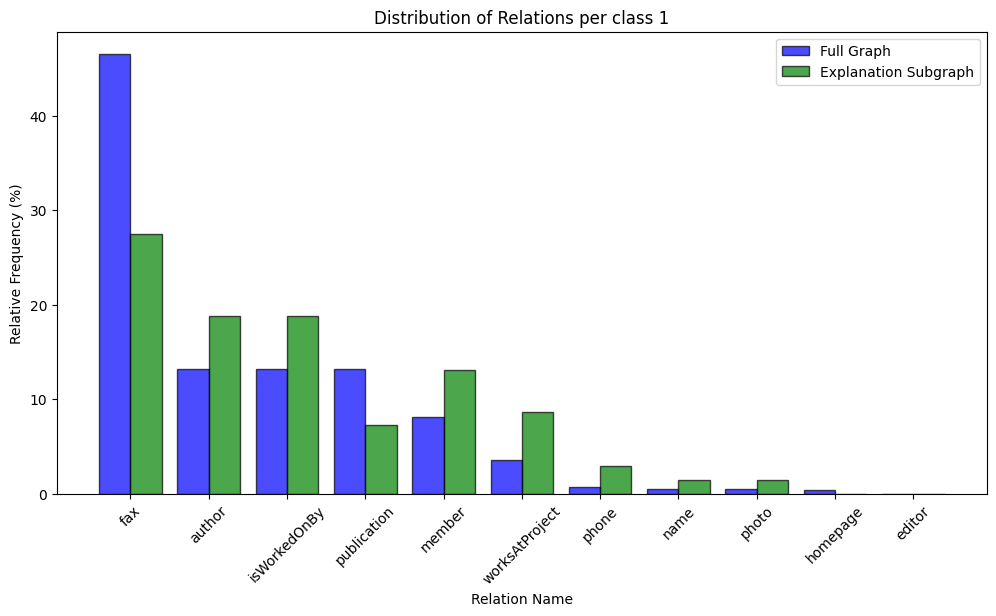

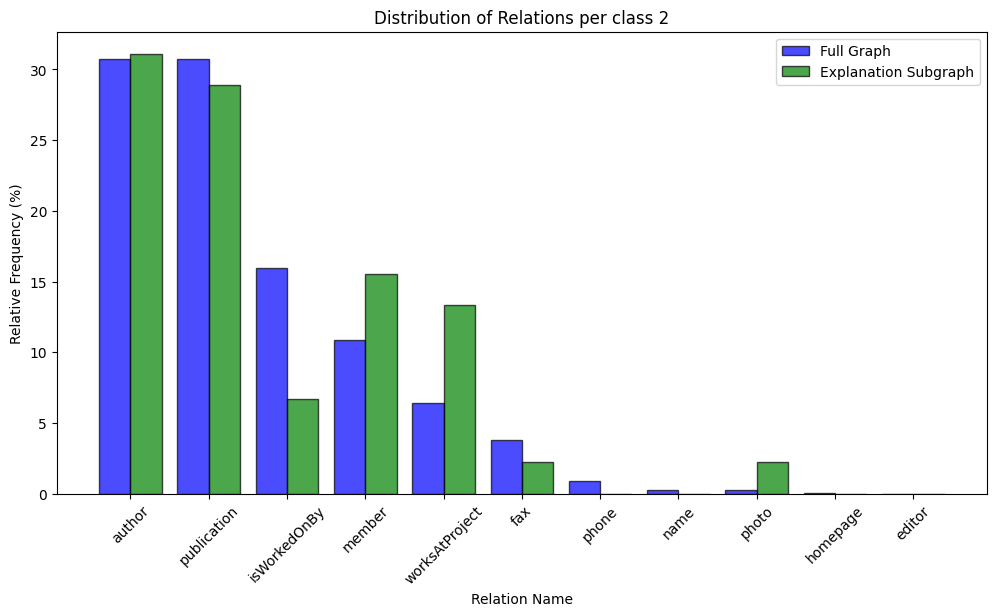

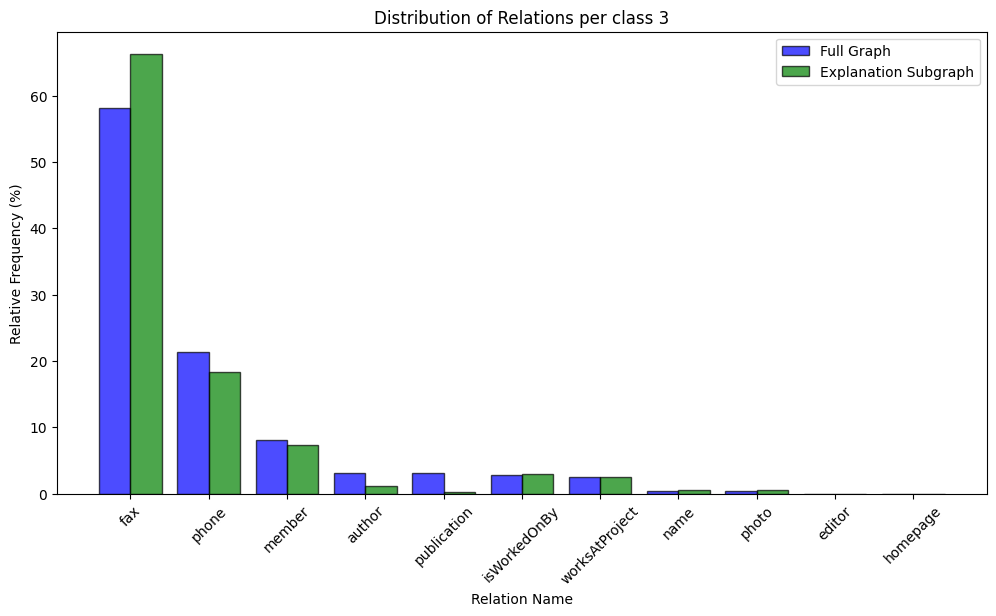

In [72]:
for label in range(data.num_classes):
    bar_plot_relations(full.loc[label].to_dict(), explain.loc[label].to_dict(),label)


In [ ]:
#statistical test about the difference between distributions of relations among classes before and after explanation

In [156]:
def metrics(path, per_class = False):
    df = pd.read_csv(path+'/Relations_Important_sample_threshold.csv', index_col = 'label')
    result_df = pd.DataFrame()
    if per_class:
        group = df.groupby('label').mean()
        result_df['label'] = group.index
    else:
        columns = ['sparsity_threshold','fidelity_minus_threshold','fidelity_plus_threshold','fidelity_minus_random','fidelity_plus_random']
        group = df[columns].mean()
    
    score = np.round(group['sparsity_threshold'],3) + np.round(group['fidelity_minus_threshold'],3) + np.round(group['fidelity_plus_threshold'],3)
    sparsity = np.round(group['sparsity_threshold'],3)
    fidelity_minus = np.round(group['fidelity_minus_threshold'],3)
    fidelity_plus = np.round(group['fidelity_plus_threshold'],3)
    fidelity_minus_random = np.round(group['fidelity_minus_random'],3)
    fidelity_plus_random = np.round(group['fidelity_plus_random'],3)
    if per_class:
        result_df['Score'] = score
        result_df['Sparsity'] = sparsity
        result_df['Fidelity-'] = fidelity_minus
        result_df['Fidelity+'] = fidelity_plus
        result_df['Fidelity- random'] = fidelity_minus_random
        result_df['Fidelity+ random'] = fidelity_plus_random


        table = result_df.to_latex(index=True, caption = path.split('/')[-2].replace('_','-'), label = path.split('/')[-2].replace('_','-'),column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')
        latex_table = table.replace('\\midrule', '\\hline')
        latex_table = latex_table.replace('\\toprule', '\\hline')
        latex_table = latex_table.replace('\\bottomrule', '\\hline')
        latex_table = latex_table.replace('\\begin{tabular}', '\\begin{adjustbox}{scale=0.5}\\begin{tabular}')  # Add scaling parameter
        latex_table = latex_table.replace('\\end{tabular}', '\\end{tabular}\\end{adjustbox}')  # Close the adjustbox environment
        print(latex_table)
    else: 
        return score, sparsity, fidelity_minus, fidelity_plus, fidelity_minus_random, fidelity_plus_random


def table_metrics_overview(name, params ):
    '''Overview of the metrics for the different initializations
    name: name of the dataset
    params: parameters of the experiment (after init)'''
    init = ['normal','const','overall_frequency','relative_frequency','inverse_relative_frequency','domain_frequency','range_frequency']

    df = pd.DataFrame(columns = ['init','Score','Sparsity', 'Fidelity-', 'Fidelity+', 'Fidelity- random', 'Fidelity+ random'])
    for i in init:
        m = metrics(f'chk/{name}_chk/exp/init_{i}_{params}/Relation_Importance')
        df.loc[len(df)] = [i] + list(m)
    df.set_index('init', inplace=True)
    table = df.to_latex(index=True, caption = 'aifb', label = 'aifb',column_format='|c|c|c|c|c|c|c|')
    latex_table = table.replace('\\midrule', '\\hline')
    latex_table = latex_table.replace('\\toprule', '\\hline')
    latex_table = latex_table.replace('\\bottomrule', '\\hline')
    latex_table = latex_table.replace('\\begin{tabular}', '\\begin{adjustbox}{scale=0.5}\\begin{tabular}')  # Add scaling parameter
    latex_table = latex_table.replace('\\end{tabular}', '\\end{tabular}\\end{adjustbox}')  # Close the adjustbox environment
    print(latex_table)
    return latex_table

result_df = metrics(path, per_class = True)
print(result_df)
#table_metrics_overview('aifb','lr_0.5_size_0.005_ent_1_type_1_wd_0.9_MFR_1_killMFR_False' )

\begin{table}
\centering
\caption{Relation-Importance}
\label{Relation-Importance}
\begin{adjustbox}{scale=0.5}\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
\hline
{} &  label &  Score &  Sparsity &  Fidelity- &  Fidelity+ &  Fidelity- random &  Fidelity+ random \\
\hline
0 &      0 &  1.985 &     0.985 &       1.00 &        0.0 &              1.00 &              0.00 \\
1 &      1 &  2.983 &     0.983 &       1.00 &        1.0 &              0.25 &              0.00 \\
2 &      2 &  2.967 &     0.967 &       1.00 &        1.0 &              0.75 &              0.00 \\
3 &      3 &  2.643 &     0.893 &       0.75 &        1.0 &              0.00 &              0.25 \\
\hline
\end{tabular}\end{adjustbox}
\end{table}

None


/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_66468/1872043904.py:26: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = result_df.to_latex(index=True, caption = path.split('/')[-2].replace('_','-'), label = path.split('/')[-2].replace('_','-'),column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')


In [159]:
result_df = metrics(path, per_class = True)
print(result_df)

\begin{table}
\centering
\caption{Relation-Importance}
\label{Relation-Importance}
\begin{adjustbox}{scale=0.5}\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
\hline
{} &  label &  Score &  Sparsity &  Fidelity- &  Fidelity+ &  Fidelity- random &  Fidelity+ random \\
\hline
0 &      0 &  2.315 &     0.982 &        1.0 &      0.333 &             0.667 &             0.333 \\
1 &      1 &  1.982 &     0.982 &        1.0 &      0.000 &             0.333 &             0.000 \\
2 &      2 &  1.990 &     0.990 &        1.0 &      0.000 &             0.333 &             0.000 \\
3 &      3 &  2.241 &     0.908 &        1.0 &      0.333 &             0.333 &             0.000 \\
\hline
\end{tabular}\end{adjustbox}
\end{table}

None


/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_66468/1872043904.py:26: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = result_df.to_latex(index=True, caption = path.split('/')[-2].replace('_','-'), label = path.split('/')[-2].replace('_','-'),column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')
